# Classifier

In [4]:
from google.colab import drive
drive.mount("/content/drive") #connect to google drive if run via browser

Mounted at /content/drive


## Intsall reuirements and import packages

In [1]:
%pip install -r /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import sys
sys.path.insert(0, '/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates')
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.model_selection import GridSearchCV #test
#from sklearn.externals import joblib
import joblib
from scipy.stats import halfcauchy
from mne.decoding import UnsupervisedSpatialFilter
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from utils import add_features
from sklearn.metrics import ConfusionMatrixDisplay
from state_prediction import *
from sliding_window_classifiers import *
import gc
np.random.seed(100)



# DEFAULT PARAMETERS - OVERRRIDEN BY PAPERMILL EXECUTION
session_id = '001'  # ID of the scanning session
output_dir = '/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives'  # Where the output data should go
n_stim = 14  # Number of stimuli
classifier_window = [-5, 6]  # Additional timepoints to use as features
classifier_center_idx_setting = 20  # The center index of the classification window, post stimulus onset
n_pca_components = [30, 60]  # Range of PCA components to try when optimising the classifier
param_optimisation_cv = 5  # Folds of CV to use in optimisation
classifier_regularisation = 'l1'  # Type of regularisation to use, l1 or l2
classifier_multiclass = 'ovr'  # Type of multi-class approach to use, ovr for one-vs-the-rest or multiclass
confusion_matrix_cv = 5  # CV to use for making the confusion matrix
n_iter_search = 100  # Number of iterations of the random search parameter optimisation procedure
cores = 1  # Number of cores to use for parallel processing
os.environ['OMP_NUM_THREADS'] = str(cores)
list_mean_accuracy = []
list_X = []

## Apply sequenceness classifier

Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/localiser/sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
002
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-002/localiser/sub-002_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection item

Mean accuracy = 0.22555555555555556


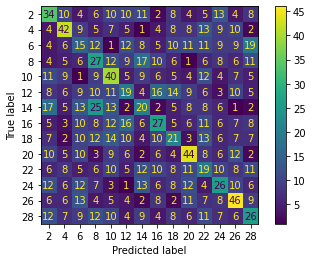

In [3]:
# Get data
localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format('001','001')) 

for session_id_int in range(2, 3):
    session_id = '{:03d}'.format(session_id_int)
    print(session_id)
    
    localiser_epochs_unconcatenate = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id,session_id))  
    localiser_epochs_unconcatenate.info = localiser_epochs.info
    localiser_epochs = mne.concatenate_epochs([localiser_epochs, localiser_epochs_unconcatenate]) 

# Get epoch data
X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
y_raw = localiser_epochs.events[:, 2]  # Get event types

# select events and time period of interest
picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
event_selector = (y_raw < n_stim * 2 + 1)
X_raw = X_raw[event_selector, ...]
y_raw = y_raw[event_selector]
X_raw = X_raw[:, picks_meg, :]

assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                np.unique(y_raw)))

times = localiser_epochs.times

prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
classifier_center_idx = prestim_samples + classifier_center_idx_setting


# Get data
X, y = (X_raw.copy(), y_raw.copy())
X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

#Create null data
# X_null = np.zeros((X.shape[0], 272, np.sum(np.abs(classifier_window))))
# for n, i in enumerate(np.random.randint(np.sum(np.abs(classifier_window)), prestim_samples, X.shape[0])):
#     X_null[n, :, :] = X_raw[n, :, i:np.sum(np.abs(classifier_window)) + i]
# y_null = np.ones(X_null.shape[0]) * 99
# X = np.vstack([X, X_null])
# y = np.hstack([y, y_null])

# Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                    FunctionTransformer(add_features, validate=False), StandardScaler(), 
                    LogisticRegression(multi_class=classifier_multiclass, C=0.1, penalty=classifier_regularisation, solver='saga', max_iter=100000, tol=0.2, class_weight="balanced"))
# # Parameter distributions passed to the random search procedure
param_dist = {"unsupervisedspatialfilter__estimator__n_components": range(*n_pca_components),
            "logisticregression__C": halfcauchy(scale=5)}

# # run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                n_iter=n_iter_search, cv=param_optimisation_cv, n_jobs=8, scoring='accuracy', verbose=True)
random_search.fit(X, y)

# # Produce a dataframe of the search results
results = pd.DataFrame(random_search.cv_results_)

#print("Parameter optimisation done")


init_notebook_mode(connected=True)

trace = go.Mesh3d(x=results.param_logisticregression__C,
                y=results.param_unsupervisedspatialfilter__estimator__n_components,
                z=results.mean_test_score, 
                color='#275fb5', opacity=0.20)

layout = go.Layout(
    title='Hyperparameter optimisation results',
    autosize=True,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(
        title='Logistic regression C'),
    yaxis = dict(
        title='PCA N components'),
    zaxis = dict(
        title='Mean accuracy'),)
)

fig = go.Figure(data=[trace], layout=layout)
#iplot(fig)


clf.set_params(**random_search.best_params_)

# Get predictions with 5 fold CV
y_pred = cross_val_predict(clf, X, y, cv=confusion_matrix_cv)
mean_conf_mat = confusion_matrix(y, y_pred)
mean_accuracy = accuracy_score(y[y != 99], y_pred[y != 99])
mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
list_mean_accuracy.append(mean_accuracy)
print("Mean accuracy = {0}".format(mean_accuracy))
    
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
plt.show()


# #save
# if not os.path.exists(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx))):
#     os.makedirs(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx)))
# joblib.dump(random_search.best_estimator_ , os.path.join(output_dir, 'classifier', 
#                                                         'classifier_idx_{0}'.format(classifier_center_idx), 'sub-{0}_classifier_idx_{1}.pkl').format(session_id, classifier_center_idx))

# accuracy_data = {
#     'mean_accuracy': mean_accuracy,
#     'best_C': random_search.best_params_['logisticregression__C'],
#     'best_n_components': random_search.best_params_['unsupervisedspatialfilter__estimator__n_components']
# }

# with open(os.path.join(output_dir, 'classifier', 'sub-{0}_classifier_info.json'), 'w') as f:
#     json.dump(accuracy_data, f)

# if not os.path.exists(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx))):
#     os.makedirs(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx)))
# np.save(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'sub-{0}_confusion_matrix_idx_{1}.pkl').format(session_id, classifier_center_idx), mean_conf_mat)

# print(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx), 'sub-{0}_classifier_idx_{1}.pkl').format(session_id, classifier_center_idx))
# print(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx)))
# print(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'sub-{0}_confusion_matrix_idx_{1}.pkl').format(session_id, classifier_center_idx), mean_conf_mat)

## Loop to transform X data for each subject without running classification

In [ ]:
for session_id_int in range(1, 2):
    gc.collect()
    session_id = '{:03d}'.format(session_id_int)
    print(session_id)

    # Get data
    localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id,session_id))  

    # Get epoch data
    X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
    y_raw = localiser_epochs.events[:, 2]  # Get event types

    # select events and time period of interest
    picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
    event_selector = (y_raw < n_stim * 2 + 1)
    X_raw = X_raw[event_selector, ...]
    y_raw = y_raw[event_selector]
    X_raw = X_raw[:, picks_meg, :]

    assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

    print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                    np.unique(y_raw)))

    times = localiser_epochs.times

    prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
    classifier_center_idx = prestim_samples + classifier_center_idx_setting


    # Get data
    X, y = (X_raw.copy(), y_raw.copy())
    X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

    # Preprocess using _clf
    _clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                        FunctionTransformer(add_features, validate=False), StandardScaler())
    
    # Add the new X to a list or something
    _X = _clf.fit_transform(X)
    list_X.append(_X)


001
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/localiser/sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]


# Followings are tests

## Concatenate the input data

In [ ]:
X_append = []
for session_id_int in range(1, 29):
    session_id = '{:03d}'.format(session_id_int)
    print(session_id)
    # Get data
    # if session_id_int == 1:
        # localiser_epochs_concatenate = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-001', 'localiser', 'sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz')) 
    # else:
    localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{}', 'localiser', 'sub-{}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id,session_id))  
    # localiser_epochs.info = localiser_epochs_concatenate.info #Q:Info varies?
    # localiser_epochs_concatenate = mne.concatenate_epochs([localiser_epochs_concatenate, localiser_epochs]) 
    X_raw = localiser_epochs.get_data()
    y_raw = localiser_epochs.events[:, 2]

    picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
    event_selector = (y_raw < n_stim * 2 + 1)
    X_raw = X_raw[event_selector, ...]
    X_raw = X_raw[:, picks_meg, :]

    assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

    print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                    np.unique(y_raw)))

    times = localiser_epochs.times
    prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
    classifier_center_idx = prestim_samples + classifier_center_idx_setting

    X = X_raw.copy()
    classifier_center_idx = classifier_center_idx_setting
    X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

    X_append.append(X)
    
# for epoch in localiser_epochs_concatenate:
#     print(epoch.shape)
# localiser_epochs = mne.concatenate_epochs(localiser_epochs_concatenate)

X_append_correct = [i for i in X_append if i.shape[0] == 900]

X_4D = np.stack(X_append_correct)


001
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/localiser/sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
002
Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-002/localiser/sub-002_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not

## Test for sequenceness classifier with concatenated data

In [ ]:
X_4D.shape

(24, 900, 272, 11)

Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Mean accuracy = 0.4488888888888889


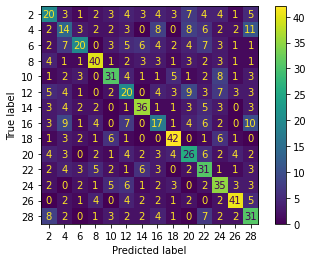

In [ ]:
# Get epoch data
X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
y_raw = localiser_epochs.events[:, 2]  # Get event types

# select events and time period of interest
picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
event_selector = (y_raw < n_stim * 2 + 1)
X_raw = X_raw[event_selector, ...]
y_raw = y_raw[event_selector]
X_raw = X_raw[:, picks_meg, :]

assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                np.unique(y_raw)))

times = localiser_epochs.times

prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
classifier_center_idx = prestim_samples + classifier_center_idx_setting


# Get data
X, y = (X_raw.copy(), y_raw.copy())
X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

#Create null data
# X_null = np.zeros((X.shape[0], 272, np.sum(np.abs(classifier_window))))
# for n, i in enumerate(np.random.randint(np.sum(np.abs(classifier_window)), prestim_samples, X.shape[0])):
#     X_null[n, :, :] = X_raw[n, :, i:np.sum(np.abs(classifier_window)) + i]
# y_null = np.ones(X_null.shape[0]) * 99
# X = np.vstack([X, X_null])
# y = np.hstack([y, y_null])

# # Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                    FunctionTransformer(add_features, validate=False), StandardScaler(), 
                    LogisticRegression(multi_class=classifier_multiclass, C=0.1, penalty=classifier_regularisation, solver='saga', max_iter=100000, tol=0.2, class_weight="balanced"))
# # Parameter distributions passed to the random search procedure
param_dist = {"unsupervisedspatialfilter__estimator__n_components": range(*n_pca_components),
            "logisticregression__C": halfcauchy(scale=5)}

# # run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                n_iter=n_iter_search, cv=param_optimisation_cv, n_jobs=8, scoring='accuracy', verbose=True)
random_search.fit(X, y)

# # Produce a dataframe of the search results
results = pd.DataFrame(random_search.cv_results_)

#print("Parameter optimisation done")


init_notebook_mode(connected=True)

trace = go.Mesh3d(x=results.param_logisticregression__C,
                y=results.param_unsupervisedspatialfilter__estimator__n_components,
                z=results.mean_test_score, 
                color='#275fb5', opacity=0.20)

layout = go.Layout(
    title='Hyperparameter optimisation results',
    autosize=True,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(
        title='Logistic regression C'),
    yaxis = dict(
        title='PCA N components'),
    zaxis = dict(
        title='Mean accuracy'),)
)

fig = go.Figure(data=[trace], layout=layout)
#iplot(fig)


clf.set_params(**random_search.best_params_)

# Get predictions with 5 fold CV
y_pred = cross_val_predict(clf, X, y, cv=confusion_matrix_cv)
mean_conf_mat = confusion_matrix(y, y_pred)
mean_accuracy = accuracy_score(y[y != 99], y_pred[y != 99])
mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
list_mean_accuracy.append(mean_accuracy)
print("Mean accuracy = {0}".format(mean_accuracy))
    
ConfusionMatrixDisplay.from_predictions(y, y_pred)
#plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
plt.show()

## GridSearchCV

Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


Mean accuracy = 0.45111111111111113


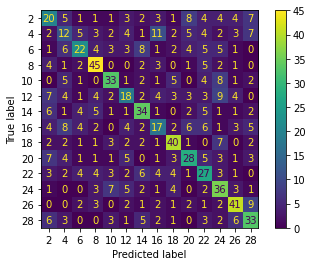

In [ ]:
# Get epoch data
X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
y_raw = localiser_epochs.events[:, 2]  # Get event types

# select events and time period of interest
picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
event_selector = (y_raw < n_stim * 2 + 1)
X_raw = X_raw[event_selector, ...]
y_raw = y_raw[event_selector]
X_raw = X_raw[:, picks_meg, :]

assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                np.unique(y_raw)))

times = localiser_epochs.times

prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
classifier_center_idx = prestim_samples + classifier_center_idx_setting


# Get data
X, y = (X_raw.copy(), y_raw.copy())
X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

#Create null data
# X_null = np.zeros((X.shape[0], 272, np.sum(np.abs(classifier_window))))
# for n, i in enumerate(np.random.randint(np.sum(np.abs(classifier_window)), prestim_samples, X.shape[0])):
#     X_null[n, :, :] = X_raw[n, :, i:np.sum(np.abs(classifier_window)) + i]
# y_null = np.ones(X_null.shape[0]) * 99
# X = np.vstack([X, X_null])
# y = np.hstack([y, y_null])

# Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                    FunctionTransformer(add_features, validate=False), StandardScaler(), 
                    LogisticRegression(multi_class=classifier_multiclass, C=0.1, penalty=classifier_regularisation, solver='saga', max_iter=100000, tol=0.2, class_weight="balanced"))
# # Parameter distributions passed to the random search procedure
param_grid_ = {"unsupervisedspatialfilter__estimator__n_components": range(*n_pca_components),
                "logisticregression__C": range(*n_pca_components)}

# # run grid search
random_search = GridSearchCV(clf, param_grid=param_grid_,
                                cv=param_optimisation_cv, n_jobs=8, scoring='accuracy', verbose=True)
random_search.fit(X, y)

# # Produce a dataframe of the search results
results = pd.DataFrame(random_search.cv_results_)

#print("Parameter optimisation done")


init_notebook_mode(connected=True)

trace = go.Mesh3d(x=results.param_logisticregression__C,
                y=results.param_unsupervisedspatialfilter__estimator__n_components,
                z=results.mean_test_score, 
                color='#275fb5', opacity=0.20)

layout = go.Layout(
    title='Hyperparameter optimisation results',
    autosize=True,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(
        title='Logistic regression C'),
    yaxis = dict(
        title='PCA N components'),
    zaxis = dict(
        title='Mean accuracy'),)
)

fig = go.Figure(data=[trace], layout=layout)
#iplot(fig)


clf.set_params(**random_search.best_params_)

# Get predictions with 5 fold CV
y_pred = cross_val_predict(clf, X, y, cv=confusion_matrix_cv)
mean_conf_mat = confusion_matrix(y, y_pred)
mean_accuracy = accuracy_score(y[y != 99], y_pred[y != 99])
mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
list_mean_accuracy.append(mean_accuracy)
print("Mean accuracy = {0}".format(mean_accuracy))
    
ConfusionMatrixDisplay.from_predictions(y, y_pred)
#plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
plt.show()

In [ ]:
print('mean accuracy= ', list_mean_accuracy)
print('X= ', list_X)

mean accuracy=  [0.22555555555555556, 0.4488888888888889, 0.45111111111111113]
X=  [array([[ 1.67084102,  1.81981215,  0.95441083, ..., -0.89742443,
        -0.75962639, -0.16029039],
       [ 0.57502468,  0.81867414,  0.45934392, ..., -2.43077006,
         0.05205246,  0.42555585],
       [-0.97654902, -0.5276468 , -0.83112727, ..., -0.22030827,
         1.04485658, -1.20613828],
       ...,
       [-1.57536624, -0.80519884,  0.15542786, ...,  0.40671173,
         1.2213945 ,  0.46473115],
       [-0.09885255, -0.00875555, -1.04205136, ...,  1.02219006,
        -0.62598616, -1.61447144],
       [ 1.20124629,  1.34701544,  1.12605671, ...,  0.85420226,
         0.70125123,  0.54394725]])]


# CNN

## Package installation and import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!pip install sklearn
!pip install tensorflow
!pip install -U dm-haiku
!pip install optax

     |████████████████████████████████| 7.5 MB 4.1 MB/s 
     |████████████████████████████████| 462 kB 4.1 MB/s 
     |████████████████████████████████| 309 kB 4.1 MB/s 
     |████████████████████████████████| 140 kB 4.1 MB/s 
     |████████████████████████████████| 72 kB 860 kB/s 


In [ ]:
!ls drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/load/code

load_data.py  __pycache__  test_load_data.py


In [ ]:
import sys
sys.path.append('drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/load/code')
from load_data import load_MEG_dataset
import haiku as hk
import jax
import optax
from jax import numpy as jnp

## load data

In [ ]:
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(1,5)], mode = 'concatenate', output_format='numpy')

Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
Loading subject 003
Data loaded
Subject 003 complete
--------------------------------------
Loading subject 004
Data loaded
Subject 004 complete
--------------------------------------


In [ ]:
# X, y = load_MEG_dataset([str(i).zfill(3) for i in range(1,5)])
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(1,5)], mode = 'concatenate', output_format='numpy')
X_test, y_test = load_MEG_dataset([str(i).zfill(3) for i in range(1,5)], mode = 'concatenate', output_format='numpy')

Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
Loading subject 003
Data loaded
Subject 003 complete
--------------------------------------
Loading subject 004
Data loaded
Subject 004 complete
--------------------------------------
Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
Loading subject 003
Data loaded
Subject 003 complete
--------------------------------------
Loading subject 004
Data loaded
Subject 004 complete
--------------------------------------


In [ ]:
X_train, X_test, y_train, y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(y_train, dtype=jnp.float32),\
                                   jnp.array(y_test, dtype=jnp.float32)

In [ ]:
import numpy as np
np.isnan(X_test).any()

False

## CNN process

In [ ]:
classes =  jnp.unique(y_train)
class CNN(hk.Module):
    def __init__(self):
        super().__init__(name="CNN")
        self.conv1 = hk.Conv2D(output_channels=32, kernel_shape=(3,3), padding="SAME")
        self.conv2 = hk.Conv2D(output_channels=16, kernel_shape=(3,3), padding="SAME")
        self.flatten = hk.Flatten()
        self.linear = hk.Linear(len(classes))

    def __call__(self, x_batch):
        x = self.conv1(x_batch)
        x = hk.MaxPool(window_shape=(2, 2), strides=(2, 2), padding='SAME')(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=(2, 2), strides=(2, 2), padding='SAME')(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = jax.nn.softmax(x)
        return x

def ConvNet(x):
    cnn = CNN()
    return cnn(x)

conv_net = hk.transform(ConvNet)        

rng = jax.random.PRNGKey(42)

params = conv_net.init(rng, X_train[:5])

print("Weights Type : {}\n".format(type(params)))

for layer_name, weights in params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(params[layer_name]["w"].shape,params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

CNN/~/conv2_d
Weights : (3, 3, 11, 32), Biases : (32,)

CNN/~/conv2_d_1
Weights : (3, 3, 16, 16), Biases : (16,)

CNN/~/linear
Weights : (544, 14), Biases : (14,)



In [ ]:
preds = conv_net.apply(params, rng, X_train[:5])

preds[:5]

DeviceArray([[0.05440806, 0.05974838, 0.04911929, 0.06157311, 0.10804811,
              0.06126059, 0.10362403, 0.05145162, 0.04764602, 0.05292974,
              0.07414541, 0.07396773, 0.09960303, 0.10247489],
             [0.03946492, 0.06339394, 0.05861948, 0.06586616, 0.10889307,
              0.05590901, 0.09560863, 0.0851321 , 0.04034037, 0.0410946 ,
              0.07252973, 0.07019497, 0.1003397 , 0.1026132 ],
             [0.03803634, 0.03918001, 0.03364867, 0.03862309, 0.17397134,
              0.0683939 , 0.07720859, 0.05817258, 0.04499368, 0.07231366,
              0.07830662, 0.06010528, 0.08290525, 0.13414103],
             [0.03550749, 0.0563261 , 0.05037626, 0.03906024, 0.10741044,
              0.08470004, 0.11599138, 0.05123251, 0.06790026, 0.05383387,
              0.07193873, 0.0823633 , 0.0639092 , 0.11945021],
             [0.03407971, 0.03356903, 0.06553856, 0.06448561, 0.09836739,
              0.07721376, 0.06487056, 0.05068876, 0.04786871, 0.07435487,
        

Loss function

In [ ]:
def CrossEntropyLoss(weights, input_data, actual):
    preds = conv_net.apply(weights, rng, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
    log_preds = jnp.log(preds)
    return - jnp.sum(one_hot_actual * log_preds)

Train

In [ ]:
def UpdateWeights(weights,gradients):
    return weights - learning_rate * gradients

In [ ]:
from jax import value_and_grad

rng = jax.random.PRNGKey(42) ## Reproducibility ## Initializes model with same weights each time.

conv_net = hk.transform(ConvNet)
params = conv_net.init(rng, X_train[:5])
epochs = 25
batch_size = 256
learning_rate = jnp.array(1/1e4)


optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(params)


for i in range(1, epochs+1):
    batches = jnp.arange((X_train.shape[0]//batch_size)+1) ### Batch Indices

    losses = [] ## Record loss of each batch
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch, Y_batch = X_train[start:end], y_train[start:end] ## Single batch of data

        loss, param_grads = value_and_grad(CrossEntropyLoss)(params, X_batch, Y_batch) ## Forward pass, loss and grads calculation
        #print(param_grads)
        updates, optimizer_state = optimizer.update(param_grads, optimizer_state) ## Calculate parameter updates
        params = optax.apply_updates(params, updates) ## Update model weights
        #params = jax.tree_map(UpdateWeights, params, param_grads) ## Update Params
        losses.append(loss) ## Record Loss

    print("CrossEntropy Loss : {:.2f}".format(jnp.array(losses).mean()))

CrossEntropy Loss : 270.54
CrossEntropy Loss : 243.51
CrossEntropy Loss : 224.93
CrossEntropy Loss : 212.50
CrossEntropy Loss : 204.71
CrossEntropy Loss : 199.96
CrossEntropy Loss : 196.96
CrossEntropy Loss : 194.88
CrossEntropy Loss : 193.25
CrossEntropy Loss : 191.88
CrossEntropy Loss : 190.66
CrossEntropy Loss : 189.54
CrossEntropy Loss : 188.50
CrossEntropy Loss : 187.52
CrossEntropy Loss : 186.58
CrossEntropy Loss : 185.68
CrossEntropy Loss : 184.82
CrossEntropy Loss : 183.98
CrossEntropy Loss : 183.17
CrossEntropy Loss : 182.38
CrossEntropy Loss : 181.61
CrossEntropy Loss : 180.85
CrossEntropy Loss : 180.11
CrossEntropy Loss : 179.37
CrossEntropy Loss : 178.64


Make prediction

In [ ]:
def MakePredictions(weights, input_data, batch_size=32):
    batches = jnp.arange((input_data.shape[0]//batch_size)+1) ### Batch Indices

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch = input_data[start:end]

        preds.append(conv_net.apply(weights, rng, X_batch))

    return preds

In [ ]:
train_preds = MakePredictions(params, X_train, 256)
train_preds = jnp.concatenate(train_preds).squeeze()
train_preds = train_preds.argmax(axis=1)

test_preds = MakePredictions(params, X_test, 256)
test_preds = jnp.concatenate(test_preds).squeeze()
test_preds = test_preds.argmax(axis=1)

Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

print("Train Accuracy : {:.3f}".format(accuracy_score(y_train, train_preds)))
print("Test  Accuracy : {:.3f}".format(accuracy_score(y_test, test_preds)))

Train Accuracy : 0.125
Test  Accuracy : 0.125


In [ ]:
from sklearn.metrics import classification_report

print("Test Classification Report ")
print(classification_report(y_test, test_preds))

Test Classification Report 
              precision    recall  f1-score   support

         2.0       0.11      0.28      0.16       194
         4.0       0.13      0.31      0.18       191
         6.0       0.12      0.23      0.15       196
         8.0       0.13      0.36      0.19       192
        10.0       0.13      0.31      0.19       190
        12.0       0.13      0.26      0.18       193
        14.0       0.00      0.00      0.00       191
        16.0       0.00      0.00      0.00       196
        18.0       0.00      0.00      0.00       191
        20.0       0.00      0.00      0.00       191
        22.0       0.00      0.00      0.00       194
        24.0       0.00      0.00      0.00       190
        26.0       0.00      0.00      0.00       195
        28.0       0.00      0.00      0.00       196

    accuracy                           0.13      2700
   macro avg       0.05      0.13      0.07      2700
weighted avg       0.05      0.13      0.07      270

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
